In [80]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import requests
import openpyxl
import urllib
from openpyxl import Workbook
from bs4 import BeautifulSoup
from openpyxl.utils.dataframe import dataframe_to_rows
from tensorflow.keras import layers
from nltk.corpus import stopwords
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
import webdriver_manager
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service

#웹드라이버 설정
options = webdriver.ChromeOptions()
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

# 환율 계산 셀(exchange) 

In [ ]:
exchange = 

# 재무제표 계산 셀(financial) 

# 유망주(삼성) 크롤링 

# 주가 예측 

In [152]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.272 Whale/2.9.118.16 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
    'Accept-Encoding': 'none',
    'Accept-Language': 'en-US,en;q=0.8',
    'Connection': 'keep-alive'}
url = "https://finance.naver.com/item/sise_day.nhn?code=001570"
df = pd.DataFrame()
page_url = '{}&page={}'.format(url, 1)
req = urllib.request.Request(page_url, headers=headers)
response = urllib.request.urlopen(req)
html = BeautifulSoup(response.read(), 'lxml')
td_pgrr = html.find('td', class_='pgRR')
s = td_pgrr.a['href'].split('=')
last_page = s[-1] 
print(last_page)
df = pd.DataFrame()
for i in range(1, int(last_page)+1):
    page_url = '{}&page={}'.format(url, i)
    req = urllib.request.Request(page_url, headers=headers)
    response = urllib.request.urlopen(req)
    html = BeautifulSoup(response.read(), 'lxml')    
    df = pd.concat([df, pd.read_html(str(html), header=0)[0]])
df = df.dropna()
print(df)
df.to_csv('./data_in/keumyang.csv', encoding='cp949')

666
            날짜       종가     전일비       시가       고가       저가        거래량
1   2023.01.03  25150.0  1700.0  24850.0  27000.0  24200.0  9130222.0
2   2023.01.02  23450.0   450.0  23400.0  24550.0  22800.0  1972335.0
3   2022.12.29  23900.0   300.0  23750.0  24300.0  23300.0  1561996.0
4   2022.12.28  23600.0  1500.0  24650.0  25000.0  23400.0  2365630.0
5   2022.12.27  25100.0  1900.0  23550.0  26000.0  23550.0  6906445.0
..         ...      ...     ...      ...      ...      ...        ...
4   1996.06.29  31000.0   800.0  32000.0  32000.0  30500.0     4390.0
5   1996.06.28  31800.0   300.0  31500.0  32000.0  31000.0    23170.0
9   1996.06.27  31500.0  1800.0  34000.0  34000.0  31400.0    12300.0
10  1996.06.26  33300.0   200.0  33900.0  34200.0  33300.0    25500.0
11  1996.06.25  33500.0     0.0  33500.0  34000.0  33000.0    27240.0

[6658 rows x 7 columns]


In [141]:
df.iloc[1149]

날짜     2018.05.04
종가         2370.0
전일비          45.0
시가         2330.0
고가         2385.0
저가         2330.0
거래량       71416.0
Name: 13, dtype: object

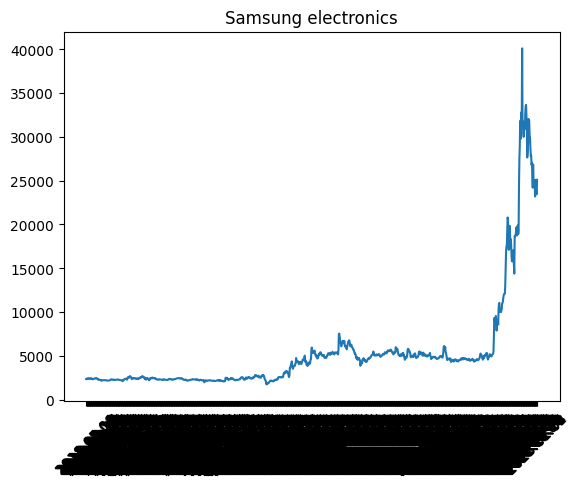

In [142]:
data = df.iloc[0:1150]
data = data.sort_values(by='날짜')
plt.title('Samsung electronics')
plt.xticks(rotation=45)
plt.plot(data['날짜'], data['종가'])

plt.show()

In [ ]:
bluechip_model = Sequential([
    layers.Embedding(vocab_size, 10, input_length=1)
    layers.LSTM(50, return_sequences=True)
    layers.LSTM(50)
    layers.Dropout(0.3)
    layers.Dense(512)
    layers.Dense(output_size, activation='softmax')
]) 
bluchip_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

promising_model = Sequential([
    layers.Embedding(vocab_size, 10, input_length=1)
    layers.LSTM(50, return_sequences=True)
    layers.LSTM(50)
    layers.Dropout(0.3)
    layers.Dense(512)
    layers.Dense(output_size, activation='softmax')
]) 
promising_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

bhistory = bluechip_model.fit(train_inputs, train_labels, batch_size=32, epochs=10)
phistory = promising_model.fit(train_inputs, train_labels, batch_size=32, epochs=10)

In [ ]:
# 환율 가중치
exw = 
# 재무제표 가중치
fw =
# 모델 가중치
w =

In [ ]:
s = input("메뉴선택 (우량주 검색-1, 유망주 검색-2) : ")
if s==0:
    forecast = exw * exchange + fw * financial + w * bluechip_model.predict(inputs)
elif s==1:
    forecast = exw * exchange + fw * financial + w * promising_model.predict(inputs)